In [1]:
import pandas as pd
from pyqubo import Constraint, Array
import neal
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridBQMSampler,  LeapHybridSampler
import dimod
import os
from dotenv import load_dotenv

In [2]:
# loading in the D-Wave Token
load_dotenv()
token_use = os.getenv("API_TOKEN")

In [3]:
data = pd.read_excel("data.xlsx")

In [4]:
columns = ["name", "position", "value", "total_points"]

In [5]:
data = data[columns]

In [6]:
df_use = data.sort_values("position").reset_index(drop=True)

In [7]:
for i in range(len(df_use)):
    df_use.loc[i, "variable"] = "x[" + str(i) + "]"
df_use

,name,position,value,total_points,variable
0,Pedro Porro,DEF,57,87,x[0]
1,Kieran Trippier,DEF,69,108,x[1]
2,William Saliba,DEF,57,108,x[2]
3,Benjamin White,DEF,56,106,x[3]
4,Oleksandr Zinchenko,DEF,50,85,x[4]
5,Gabriel dos Santos Magalhães,DEF,53,100,x[5]
6,Virgil van Dijk,DEF,64,98,x[6]
7,Fabian Schär,DEF,54,96,x[7]
8,Trent Alexander-Arnold,DEF,85,103,x[8]
9,Vitalii Mykolenko,DEF,46,82,x[9]


In [8]:
defense_list_index = list(df_use[df_use["position"]=="DEF"].index)
forward_list_index = list(df_use[df_use["position"]=="FWD"].index)
gk_list_index = list(df_use[df_use["position"]=="GK"].index)
midfield_list_index = list(df_use[df_use["position"]=="MID"].index)

In [9]:
columns = ["variable","name", "position", "value", "total_points"]

In [10]:
total_points = df_use["total_points"].to_list()
value = df_use["value"].to_list()

In [11]:
df_use = df_use[columns]

In [12]:
lagrange = 1716
lagrange_budget = 1551
num_var = 38
slack_num = 1

In [13]:
defense=4
midfield=5
forward=1

In [14]:
x = Array.create('x', shape=num_var, vartype='BINARY')
s = Array.create('s', shape=slack_num, vartype='BINARY')

In [15]:
# objective function
h = sum(n * x for x, n in zip(x, total_points))

# constraints
c1 = lagrange * Constraint((sum(x[n] for n in range(0, num_var)) - 11)**2,
                                                label='11 players team')
c2 = lagrange * Constraint((sum(x[n] for n in range(min(defense_list_index), max(defense_list_index)+1))-defense)**2,
                                                label=str(defense) + " defenders")
c3 = lagrange * Constraint((sum(x[n] for n in range(min(forward_list_index), max(forward_list_index)+1))-forward)**2,
                                                label=str(forward) + " forwards")
c4 = lagrange * Constraint((sum(x[n] for n in range(min(gk_list_index), max(gk_list_index)+1))-1)**2,
                                                label= "1 keeper")
c5 = lagrange * Constraint((sum(x[n] for n in range(min(midfield_list_index), max(midfield_list_index)+1))-midfield)**2,
                                                label=str(midfield) + " midfielders")
c6 = lagrange_budget * Constraint((sum(n * x for x, n in zip(x, value)) + s[0] -700)**2,
                                                              label="budget")

In [16]:
H = -1 * h + c1 + c2 + c3 + c4 + c5 + c6

In [17]:
model = H.compile()
qubo, offset = model.to_qubo()
bqm = model.to_bqm()

# Solve problem with QPU
api_token = token_use
sampler = LeapHybridSampler(token= api_token)
sampleset = sampler.sample(bqm,
                            label="FPL line-up optimization")

In [18]:
# Decode samples and select the best one
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

# Print to see if constraints are fulfilled
print(best_sample.constraints())

{'budget': (True, 0.0), '1 forwards': (True, 0.0), '5 midfielders': (True, 0.0), '11 players team': (True, 0.0), '4 defenders': (True, 0.0), '1 keeper': (True, 0.0)}


In [19]:
# Print results for best line-up
lineup_df = pd.DataFrame(best_sample.sample.items())
lineup_df.columns = ['variable', 'selected']
lineup_df = lineup_df[(lineup_df['variable'].str.startswith(
    'x', na=False)) & (lineup_df['selected'] == 1)]
lineup_df = df_use.merge(lineup_df, on=['variable'])

# Print line-up and maximized energy for the objective function
gk = lineup_df[lineup_df["position"] == "GK"]
defense_list = lineup_df[lineup_df["position"] == "DEF"]
midfield_list = lineup_df[lineup_df["position"] == "MID"]
attack_list = lineup_df[lineup_df["position"] == "FWD"]
ordered_lineup_df = pd.concat([gk, defense_list, midfield_list, attack_list], axis=0).reset_index(drop=True)
ordered_lineup_df = ordered_lineup_df[["name", "position", "value", "total_points"]]
print(ordered_lineup_df)
print("Total sum of points: ", ordered_lineup_df['total_points'].sum())
print("Total budget: ", ordered_lineup_df['value'].sum())

                             name position  value  total_points
0                     André Onana       GK     48            92
1                     Pedro Porro      DEF     57            87
2                  Benjamin White      DEF     56           106
3    Gabriel dos Santos Magalhães      DEF     53           100
4                    Fabian Schär      DEF     54            96
5                     Pascal Groß      MID     66           117
6                     Cole Palmer      MID     57           128
7                      Phil Foden      MID     81           147
8                    Jarrod Bowen      MID     78           125
9                   Son Heung-min      MID     97           149
10  João Pedro Junqueira de Jesus      FWD     53            83
Total sum of points:  1230
Total budget:  700


In [20]:
ordered_lineup_df["name"].tolist()

['André Onana',
 'Pedro Porro',
 'Benjamin White',
 'Gabriel dos Santos Magalhães',
 'Fabian Schär',
 'Pascal Groß',
 'Cole Palmer',
 'Phil Foden',
 'Jarrod Bowen',
 'Son Heung-min',
 'João Pedro Junqueira de Jesus']

In [21]:
line_up = ordered_lineup_df
gk_names = line_up[line_up["position"]=="GK"]["name"].to_list()
def_names = line_up[line_up["position"]=="DEF"]["name"].to_list()
mid_names = line_up[line_up["position"]=="MID"]["name"].to_list()
fwd_names = line_up[line_up["position"]=="FWD"]["name"].to_list()
gk_names, def_names, mid_names, fwd_names

(['André Onana'],
 ['Pedro Porro',
  'Benjamin White',
  'Gabriel dos Santos Magalhães',
  'Fabian Schär'],
 ['Pascal Groß', 'Cole Palmer', 'Phil Foden', 'Jarrod Bowen', 'Son Heung-min'],
 ['João Pedro Junqueira de Jesus'])

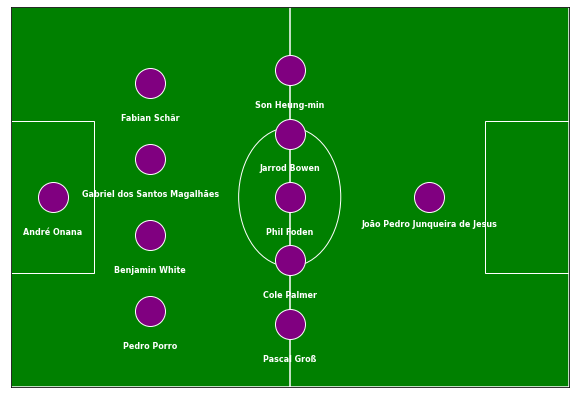

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def draw_soccer_field():
    """
    Draws a detailed soccer field with a green background, complete middle circle,
    and 18-yard boxes.
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_facecolor('green')  # Set the background color to green

    # Draw the pitch outline
    plt.plot([0, 0, 200, 200, 0], [0, 100, 100, 0, 0], color="white")

    # Draw the middle line
    plt.plot([100, 100], [0, 100], color="white")

    # Draw the complete middle circle
    center_circle = patches.Circle((100, 50), 9.15, edgecolor="white", facecolor="none")
    #ax.add_patch(center_circle)

    # Draw the D-box arcs
    left_arc = patches.Arc((100, 50), height=36.6, width=18.3*2, angle=0, theta1=270, theta2=90, color="white")
    right_arc = patches.Arc((50*2, 25*2), height=18.3*2, width=18.3*2, angle=0, theta1=90, theta2=270, color="white")
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)

    # Draw the 18-yard boxes
    # Left 18-yard box (from the perspective of the viewer)
    ax.add_patch(patches.Rectangle((0, 15*2), 15*2, 20*2, edgecolor="white", facecolor="none"))
    # Right 18-yard box
    ax.add_patch(patches.Rectangle(((100-15)*2, 15*2), 15*2, 20*2, edgecolor="white", facecolor="none"))

    # Set limits and turn off axis
    plt.xlim(0, 100*2)
    plt.ylim(0, 50*2)
    #plt.axis('off')
    # Remove the tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Remove the ticks
    ax.set_xticks([])
    ax.set_yticks([])


    return fig, ax

def plot_formation(line_up):
    """
    Plots the given formation on a detailed soccer field.
    """
    fig, ax = draw_soccer_field()
    
    gk_names = line_up[line_up["position"]=="GK"]["name"].to_list()
    def_names = line_up[line_up["position"]=="DEF"]["name"].to_list()
    mid_names = line_up[line_up["position"]=="MID"]["name"].to_list()
    fwd_names = line_up[line_up["position"]=="FWD"]["name"].to_list()
    
    ax.plot(15, 50, 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
    ax.text(15, 50 - 8, gk_names[0], ha="center", va="top", color="white", fontsize=8, fontweight="bold")  # Player name
    
    def_len = len(def_names)
    def_num = list(np.linspace(0, 100, def_len+2))[1:-1]
    for i in range(len(def_num)):
        ax.plot(50, def_num[i], 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
        ax.text(50, def_num[i] - 8, def_names[i], ha="center", va="top", color="white", fontsize=8, fontweight="bold")  # Player name
        
    mid_len = len(mid_names)
    mid_num = list(np.linspace(0, 100, mid_len+2))[1:-1]
    for i in range(len(mid_num)):
        ax.plot(100, mid_num[i], 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
        ax.text(100, mid_num[i] - 8, mid_names[i], ha="center", va="top", color="white", fontsize=8, fontweight="bold")  # Player name

    fwd_len = len(fwd_names)
    fwd_num = list(np.linspace(0, 100, fwd_len+2))[1:-1]
    for i in range(len(fwd_num)):
        ax.plot(150, fwd_num[i], 'o', markersize=30, color="purple", markeredgecolor="white")  # Player icon
        ax.text(150, fwd_num[i] - 6, fwd_names[i], ha="center", va="top", color="white", fontsize=8, fontweight="bold")  # Player name
    plt.show()
    
# Example: 4-3-3 formation with player roles
formation = plot_formation(line_up)

formation
